# Reinforcement Learning and the Cartpole 

The cartpole is a control theory task where the goal is to balance a pole on a cart that sits on a one dimensional track.  You can push the cart left and right to balance the pole.

In this lecture we will use a neural network to learn a policy that tells us whether to push the cart left or right depending on the angle of the pole, the position of the cart, and the velocity of the cart.

We will train this neural network using reinforcement learning.  This is a technique where you have the agent (the neural network) run through the task over and over again, and update its policy (parameters of the neural network) based on its performance.

There are many algorithms that do reinforcement learning.  In this notebook we will use one called policy gradient.

This code comes from https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/blob/master/Chapter09/02_cartpole_reinforce.py

# Clones, Installs, Imports

## Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [1]:
!git clone https://github.com/zlisto/reinforcement_learning_tutorial

import os
os.chdir("reinforcement_learning_tutorial")

Cloning into 'reinforcement_learning_tutorial'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 1), reused 12 (delta 1), pack-reused 0
Unpacking objects: 100% (12/12), done.


## Install Packages

In [2]:
!pip install gym pyvirtualdisplay ptan
!apt-get install -y xvfb python-opengl ffmpeg 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.7 MB 4.1 kB/s 
  Created wheel for ptan: filename=ptan-0.7-py3-none-any.whl size=23505 sha256=b463f0da579ea31ff4a55b031e0fb7ea2414d44bff1aa2e8a14c4586c8582a5a
  Stored in directory: /root/.cache/pip/wheels/60/72/3d/a3c47193fdb9efd08e3a54398af996b2989c68571813a71256
Successfully built ptan
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.7.0 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torc

## Import Librarires

There are three main libraries we will import.

1) `gym` - this has the simulation environment. 

2) `torch` - this does the neural network training.  

3) `ptan` - this has the agent wrapper we need to have the agent interact with the simulator.  

The other libraries help with visualizing the Cart Pole simulation.

In [3]:
from scripts.rl_helper import *
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

import ptan
import torch


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

display = Display(visible=0, size=(1400, 900))
display.start()

# Cartpole Environment
The name of the simulator environment is `"CartPole-v1"`, which we save to a variable `env_name`.  We can load the cart pole simulator environment with the `gym.make` function.  We use the `wrap_env` function so we can visualize the output of the simulator in Colab.

Note: You can load many different gym simulator environments with this line of code.  Just change `env_name`.  You can find a list of the gym environments here: https://www.gymlibrary.ml/

In [43]:
env_name = "CartPole-v1"
env = wrap_env(gym.make(env_name))

query_environment(env_name)

Action Space: Discrete(2)
Observation Space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Max Episode Steps: 500
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 475.0


This code will run through the simulator and visualize it.  We use a random choice for the `action` of the agent.  The simulation stops when the pole tilts too far to the right or too far to the left. The score of the agent is the number of steps the simulation runs for, with a maximum value of 500.

Each time we run a step in the simulator,  we give an `action`, and the `env.step` function returns an `observation` of the state (pole angle, pole angular velocity, cart position, cart velocity), the current `reward` (it is 1 always), and a `done` variable that is `TRUE` if the pole tilted too far, or if we went 500 steps. 

We start the simulator by doing `env.reset()`, then use a `for` loop to run through the simulator one step at a time.  At the end we print out the score of the agent (how long it could balance the pole for), and we show a video of the agent balancing the pole on the cart.

In [44]:
env = wrap_env(gym.make(env_name))
observation = env.reset()
score = 0
step = 0
while True:
  env.render()
  step+=1
  # your agent goes here
  action = env.action_space.sample()
  observation, reward, done, _ = env.step(action)
  score+=reward
  if done:
      break
print(f"{env_name} Score = {score}, Steps = {step}")
env.close()
show_video()


CartPole-v1 Score = 16.0, Steps = 16


# Neural Network for Agent

## Create Neural Network for Policy
This `PGN` class defines the Policy Gradient Network.  This is just a neural network for the policy.  To create the network, you specify the `input_size` and `output_size`.  The `input_size` is the size of the state and the `output_size` is the number of actions.  

We can pick how many neurons we went inside the network with the `num_neurons` variable.  We set it to 128 for now.  You can try adding more and see if it makes the agent perform better.

In [45]:
class PGN(nn.Module):
    def __init__(self, input_size, num_actions):
        super(PGN, self).__init__()
        num_neurons = 128
        self.net = nn.Sequential(
            nn.Linear(input_size, num_neurons),
            nn.ReLU(),
            nn.Linear(num_neurons, num_actions)
        )

    def forward(self, x):
        return self.net(x)

# Train Agent Using Policy Gradient

## Initialize Learning Parameters
We set some parameters for the policy gradient algorithm.

1) `winning_score` = what score the agent needs to achieve to beat the simulator.

2) `GAMMA`   discount factor

3) `LEARNING_RATE` = gradient ascent step size

4) `EPISODES_TO_TRAIN` = number of episodes per batch when we do the gradient step

5) `filename_agent` = file where we will save the trained agent's neural network.


In [48]:
winning_score = 490
GAMMA = 0.99
LEARNING_RATE = 0.01
EPISODES_TO_TRAIN = 4
filename_agent = f'{env_name}_pg_agent'


## Initialize Some Other Stuff


1) `env` = the simulation environment.  We will use the `env_name` variable here  (you can change this to other environments if you want).

2) `net` = policy network  (neural network for the policy)

3) `agent` = an object that can play in the simulation and use the policy network to make actions.

4) `exp_source` = a generator that spits out a step of the simulator with the agent running the policy.

5) `optimizer` = the object that will do the gradient calculation and step for us.

In [49]:
env = wrap_env(gym.make(env_name))

num_actions = env.action_space.n
net = PGN(env.observation_space.shape[0], num_actions)
agent = ptan.agent.PolicyAgent(net, preprocessor=ptan.agent.float32_preprocessor,
                               apply_softmax=True)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA)

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

scores = []
step_idx = 0
done_episodes = 0

batch_episodes = 0
batch_states = [] 
batch_actions = [] 
batch_qvals = []
cur_rewards = []


## Train Agent with Policy Gradient

This `for` loop will run policy gradient to train the agent.  It will print out the current score of the agent in the simulator, along with the average of the last 10 scores.  Hopefully we see the score increase as the agent learns to balance the pole.

In [50]:
for step_idx, exp in enumerate(exp_source):
    batch_states.append(exp.state)
    batch_actions.append(int(exp.action))
    cur_rewards.append(exp.reward)
    
  
    if exp.last_state is None:  #episode is done
        batch_qvals.extend(calc_qvals(cur_rewards,GAMMA))
        cur_rewards.clear()
        batch_episodes += 1


    # handle new rewards
    new_rewards = exp_source.pop_total_rewards()
    if new_rewards:
        score = new_rewards[0]
        scores.append(score)
        mean_score = float(np.mean(scores[-100:]))
        if done_episodes%100==0: 
            print("Episode %d, score: %6.2f, last 100 episodes avg score= %6.2f" % (
            done_episodes,score,mean_score))
        
        #condition when agent has "learned" to beat the simulator
        if mean_score >=winning_score:
            print("Solved in %d steps and %d episodes!  Score = %.1f" % (step_idx, done_episodes,mean_score))
            torch.save(net.state_dict(),filename_agent)
            break
        done_episodes += 1

    if batch_episodes < EPISODES_TO_TRAIN:
        continue

    optimizer.zero_grad()
    states_v = torch.FloatTensor(batch_states)
    batch_actions_t = torch.LongTensor(batch_actions)
    batch_qvals_v = torch.FloatTensor(batch_qvals)

    logits_v = net(states_v)
    log_prob_v = F.log_softmax(logits_v, dim=1)
    log_prob_actions_v = batch_qvals_v * log_prob_v[range(len(batch_states)), batch_actions_t]
    loss_v = -log_prob_actions_v.mean()

    loss_v.backward()  #take gradient
    optimizer.step()   #update paramters

    #clear out the batch after updating neural network
    batch_episodes = 0
    batch_states.clear()
    batch_actions.clear()
    batch_qvals.clear()

Episode 0, score:  17.00, last 100 episodes avg score=  17.00
Episode 100, score: 154.00, last 100 episodes avg score=  67.92
Episode 200, score: 402.00, last 100 episodes avg score= 361.25
Episode 300, score: 309.00, last 100 episodes avg score= 444.80
Episode 400, score: 296.00, last 100 episodes avg score= 337.48
Episode 500, score: 500.00, last 100 episodes avg score= 421.61
Episode 600, score: 500.00, last 100 episodes avg score= 468.12
Solved in 235635 steps and 651 episodes!  Score = 492.7


## Plot Agent's Performance vs Episode
Plot the average score of the agent (how long it balanced the pole for) versus the episode it played.

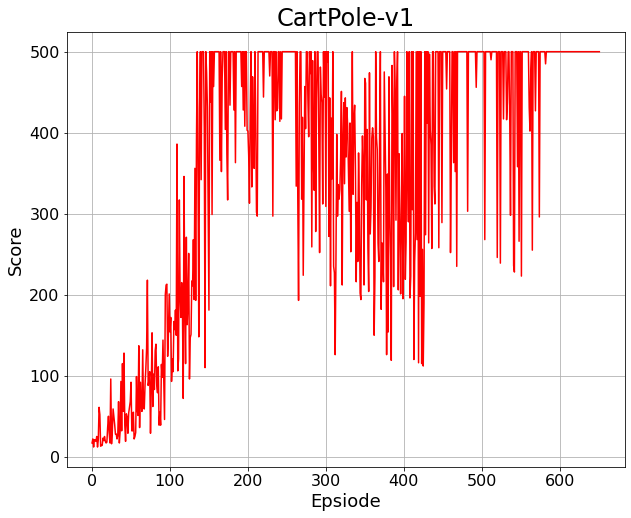

In [51]:
#plot the scores
df = pd.DataFrame({'episode':[x for x in range(len(scores))],
                   'score':scores})
fig = plt.figure(figsize = (10,8))
sns.lineplot(data = df, x = 'episode', y = 'score', color = 'red')
plt.ylabel('Score',fontsize = 18)
plt.xlabel('Epsiode', fontsize = 18)
plt.title(f"{env_name}", fontsize = 24)
plt.grid()
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.show()



# Trained Agent Performance

## Load the Trained Agent
You can load the trained agent you saved here.  Make sure you have the right filename_agent.

We create two agents:  agent_dumb and agent_smart.

In [52]:
#Load trained agent
filename_agent = f'{env_name}_pg_agent'


net_trained = PGN(env.observation_space.shape[0], env.action_space.n)
net_trained.load_state_dict(torch.load(filename_agent))
net_trained.eval()

agent_trained = ptan.agent.PolicyAgent(net_trained, preprocessor=ptan.agent.float32_preprocessor,
                               apply_softmax=True)


## Run Trained Agent in Enviornment
This cell lets you see how the trained agent performs.

In [54]:
env = wrap_env(gym.make(env_name))
observation = env.reset()
score = 0
step = 0

while True:
  env.render()
  step+=1
  # your agent goes here
  observation_tensor = torch.tensor([observation])
  action = agent_trained(observation_tensor)[0][0]

  observation, reward, done, info = env.step(action)
  score+=reward
  if done:
      break
print(f"Score = {score}, Steps = {step}")
env.close()
show_video()

Score = 500.0, Steps = 500
